In [45]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

# Metropolis-Asting

In [53]:
def multinorm(x, mu, cov):
    return jnp.exp(-0.5 * (x - mu).T @ jnp.linalg.inv(cov) @ (x - mu)) / jnp.sqrt(2 * np.pi * jnp.linalg.det(cov)**2) 
def exp(x):
    if x > 0:
        return np.exp(-1 / 5 * x) 
    else:
        return -np.inf

In [7]:
mu = np.array([0, 2])
cov = np.array([[1, 0.3], 
                [0.3, 1]])
x = np.array([0, 1])
multinorm(x, mu, cov)

DeviceArray(0.2530727, dtype=float32)

In [27]:
def run_step(vec, f, step):
    new_vec = np.random.normal(loc=vec, scale=step)
    alpha = f(new_vec) / f(vec)
    if np.random.random() <= alpha:
        return new_vec
    else:
        return vec
    
def run_chain(init, nstep, f, step=1):
    chain = np.array([[init[i] for i in range(len(init))]])
    for n in range(nstep):
        new = run_step(chain[-1], f, step)
        chain = np.vstack((chain, new))
    return chain

In [30]:
mu = np.array([0, 2])
cov = np.array([[1, 0.3], 
                [0.3, 1]])
f = lambda x: multinorm(x, mu, cov)
init = np.array([0, 1.5])
chain = run_chain(init, 100000, f)

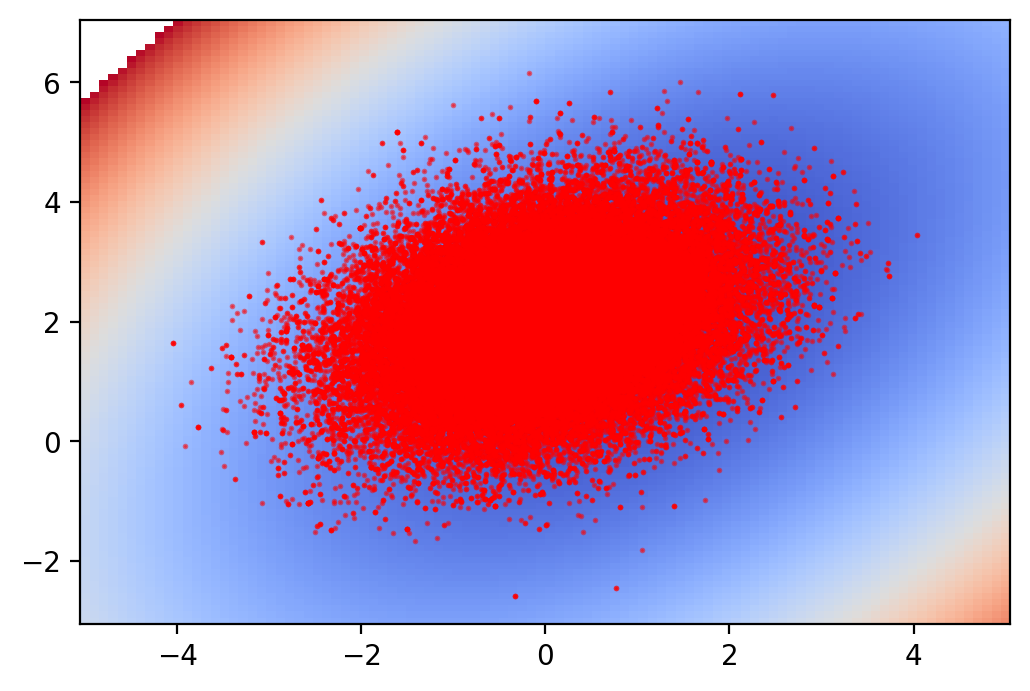

In [97]:
plt.figure(dpi=200)
X, Y = np.meshgrid(np.linspace(mu[0] - 5 * np.sqrt(cov[0, 0]), mu[0] +  5 * np.sqrt(cov[0, 0]), 100),
                   np.linspace(mu[1] - 5 * np.sqrt(cov[1, 1]), mu[1] +  5 * np.sqrt(cov[1, 1]), 100))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = f(np.array([X[i, j], Y[i, j]]))
plt.pcolormesh(X, Y, Z, cmap='coolwarm')
plt.scatter(*chain.T, s=1, c='r', alpha=0.5)


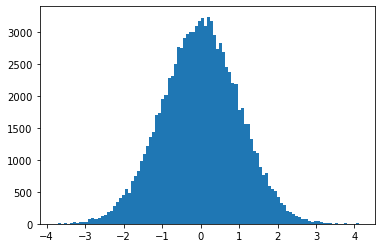

In [149]:
plt.hist(chain.T[0], bins=100);

In [145]:
burn = int(len(chain) / 2)
for i, c in enumerate(chain.T):
    median = np.median(chain.T[i][burn:])
    e_plus = np.quantile(chain.T[i][burn:], 0.82) - np.median(chain.T[i][burn:])
    e_neg = np.median(chain.T[i][burn:]) - np.quantile(chain.T[i][burn:], 0.18)
    print(f'Par n°{i}')
    print(f'mean = {median:.3f} + {e_plus:.3f} - {e_neg:.3f}')

Par n°0
mean = -0.005 + 0.897 - 0.935
Par n°1
mean = 2.019 + 0.914 - 0.934


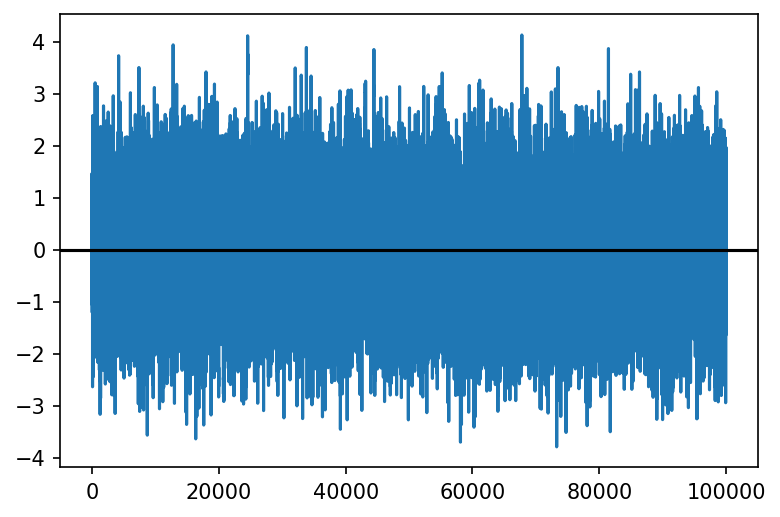

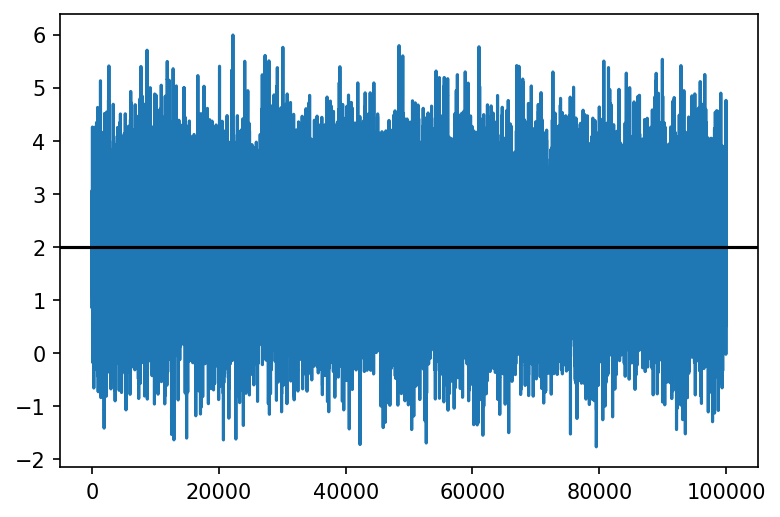

In [143]:
plt.figure(dpi=150)
plt.plot(np.arange(len(chain.T[0])), chain.T[0])
plt.axhline(mu[0], c='k')

plt.figure(dpi=150)
plt.plot(np.arange(len(chain.T[1])), chain.T[1])
plt.axhline(mu[1], c='k')

In [160]:
f(1)

In [174]:
f = lambda x: exp(x)
init = np.array([1.])
chain = run_chain(init, 10000, f)


(array([4580., 2655., 1352.,  629.,  436.,  179.,   83.,   34.,   34.,
          19.]),
 array([7.34400611e-04, 2.69546414e+00, 5.39019388e+00, 8.08492362e+00,
        1.07796534e+01, 1.34743831e+01, 1.61691128e+01, 1.88638426e+01,
        2.15585723e+01, 2.42533020e+01, 2.69480318e+01]),
 <BarContainer object of 10 artists>)

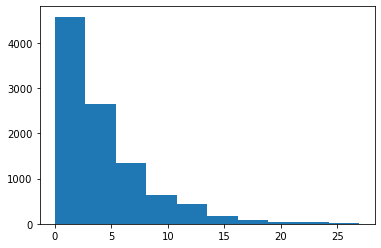

In [188]:
x = np.linspace(0, 10, 1000)
plt.hist(chain)

# Hamiltonian MCMC

Halmitonain equations:
$$
\frac{d q_i}{dt} = \frac{\partial H}{\partial p_i} \\
\frac{d p_i}{dt} = -  \frac{\partial H}{\partial q_i}
$$

## Hamiltonian trajectories

$$H = -\ln(f) + E_c$$

TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

## Leapfrog integration

The goal of leapfrog integration is

In [122]:
def leapfrog_int(q, p, dVdq, path_len, step_size):
    q = np.copy(q)
    p = np.copy(p)
    
    qlist = [q]
    plist = [p]
    
    p -= dVdq(q) * step_size / 2 # demi-step
    for _ in range(int(path_len / step_size) - 1):
        # 1 step
        q += p * step_size 
        p -= dVdq(q) * step_size
    
    q += p * step_size # Last step
    p -= dVdq(q) * step_size / 2 # Last demi-step
    return q, p

## 2D multivariate normal

In [164]:
def multivar_norm(x):
    return jnp.exp(-0.5 * jnp.sum(jnp.square(x)))
def f(x):
    return -jnp.log(multivar_norm(x)) - 5

In [165]:
r = jnp.linspace(0, 5, 100)
coord = jnp.vstack((r, jnp.zeros_like(r)))
val = jax.vmap(f)(coord.T)


Text(0.5, 0, 'r')

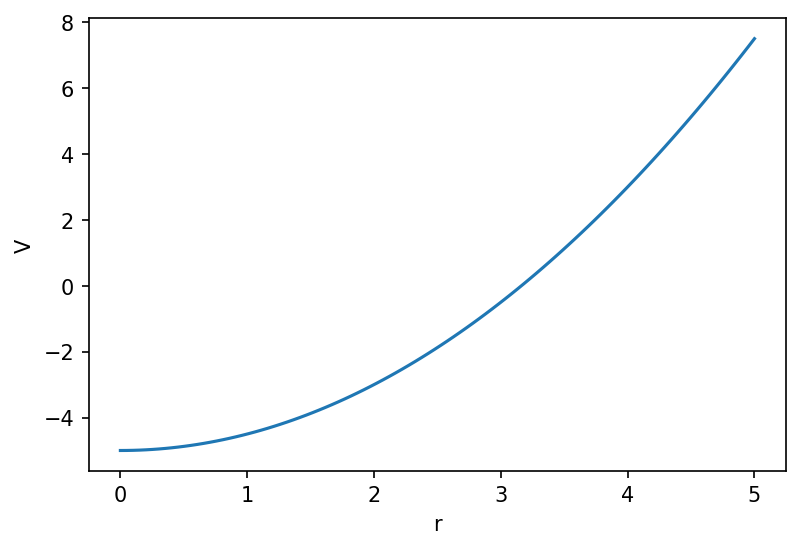

In [166]:
plt.figure(dpi=150)
plt.plot(r, val)
plt.ylabel('V')
plt.xlabel('r')

In [167]:
X, Y = np.meshgrid(np.linspace(-5, 5, 100),
                   np.linspace(-5, 5, 100))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = multivar_norm(np.array([X[i, j], Y[i, j]]))

In [209]:
# Stable trajectory
path_len = 0.1
step_size = 0.01
q_ini = jnp.array([1., 0.])
p_ini = jnp.array([0., 4.])
ql = [q_ini]
pl = [p_ini]
for i in range(60):
    q, p = leapfrog_int(ql[-1], pl[-1], jax.grad(f), path_len, step_size)
    ql.append(q)
    pl.append(p)
ql = np.array(ql)
pl = np.array(pl)

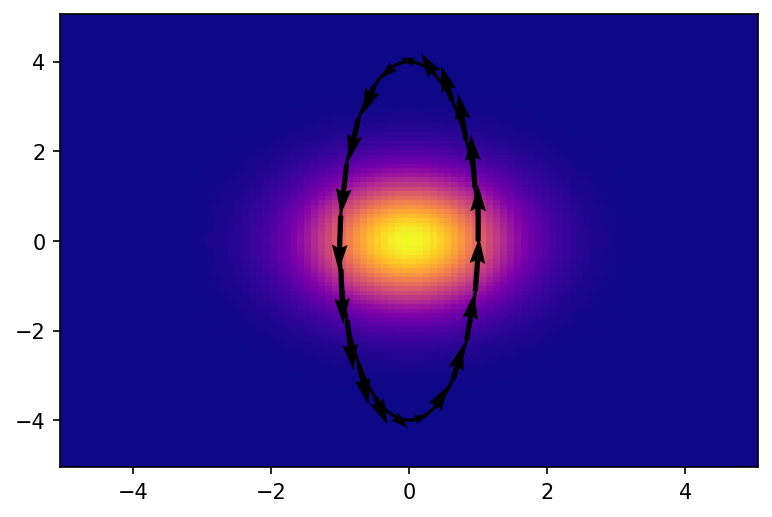

In [210]:
plt.figure(dpi=150)
plt.pcolormesh(X, Y, Z, cmap='plasma')

plt.plot(ql.T[0], ql.T[1], c='k')
plt.quiver(ql.T[0][::3], ql.T[1][::3], pl.T[0][::3], pl.T[1][::3], scale=50)

## Arbitrary 1D gaussian

In [265]:
def gauss(x):
    return jnp.exp(-0.5 * x**2) / jnp.sqrt(2 * np.pi)

def f(x):
    return -jnp.log(gauss(x))

def HMC_chain_scalar(nstep, q_ini, nlogprob, path_len=1., step_size=0.5):
    dVdq = jax.grad(nlogprob)
    samples = [q_ini]
    
    for n in range(nstep):
        p_ini = np.random.normal(0, 1)
        qnew, pnew = leapfrog_int(samples[-1], p_ini, dVdq, path_len, step_size)
        dH = nlogprob(samples[-1]) + 0.5 * jnp.sum(jnp.square(p_ini))
        dH -=  nlogprob(qnew) + 0.5 * jnp.sum(jnp.square(pnew))
        if np.random.random() <= jnp.exp(-dH):
            samples.append(qnew)
        else:
            samples.append(samples[-1])
    return np.array(samples)

In [272]:
chain = HMC_chain_scalar(2000, 1., f)

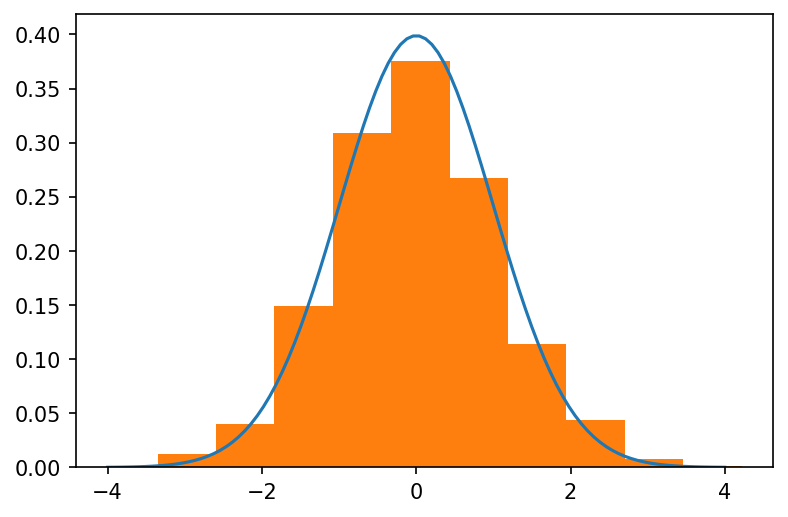

In [274]:
x= np.linspace(-4, 4, 100)
plt.figure(dpi=150)
plt.plot(x, gauss(x))
plt.hist(chain,density=True,bins=10);

In [ ]:
plt.figure(dpi=150)
plt.plot(np.arange(len(chain)), chain)
plt.axhline(mu[0], c='k')


## Arbitrary 2D multinormal

In [221]:
mu = jnp.array([1., 2.])
cov = jnp.array([[0.5, 0.3], 
                 [0.3, 0.7]])
def f(x):
    return -jnp.log(multinorm(x, mu=mu, cov=cov))

In [212]:
path_len = 0.1
step_size = 0.01
q_ini = jnp.array([2., 3.3])
p_ini = jnp.array([1., -1.])
ql = [q_ini]
pl = [p_ini]
for i in range(200):
    q, p = leapfrog_int(ql[-1], pl[-1], jax.grad(f), path_len, step_size)
    ql.append(q)
    pl.append(p)
ql = np.array(ql)
pl = np.array(pl)

In [213]:
X, Y = np.meshgrid(np.linspace(mu[0] - 5 * np.sqrt(cov[0, 0]), mu[0] +  5 * np.sqrt(cov[0, 0]), 100),
                   np.linspace(mu[1] - 5 * np.sqrt(cov[1, 1]), mu[1] +  5 * np.sqrt(cov[1, 1]), 100))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = multinorm(np.array([X[i, j], Y[i, j]]), mu=mu, cov=cov)

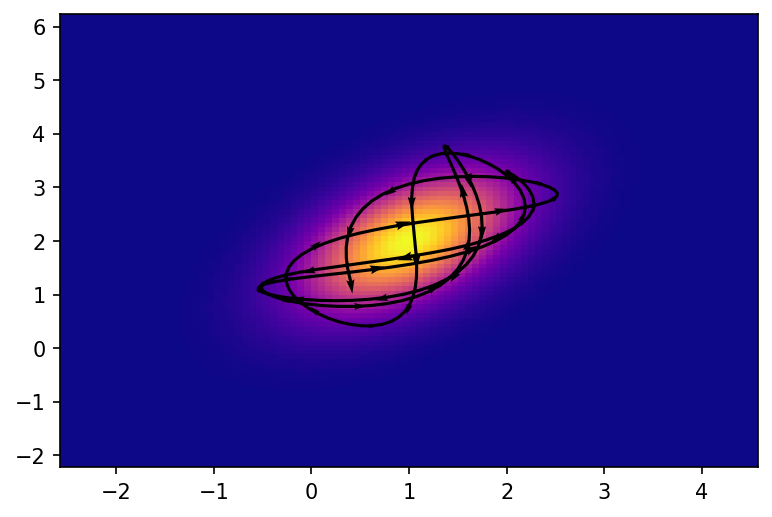

In [218]:
plt.figure(dpi=150)
plt.pcolormesh(X, Y, Z, cmap='plasma')

plt.plot(ql.T[0], ql.T[1], c='k')
plt.quiver(ql.T[0][::5], ql.T[1][::5], pl.T[0][::5], pl.T[1][::5], scale=100)

## HMC code

In [239]:
def HMC_chain(nstep, q_ini, nlogprob, path_len=1., step_size=0.5):
    dVdq = jax.grad(nlogprob)
    samples = [q_ini]
    
    for n in range(nstep):
        p_ini = np.random.normal(0, 1, size=len(q_ini))
        qnew, pnew = leapfrog_int(samples[-1], p_ini, dVdq, path_len, step_size)
        dH = nlogprob(samples[-1]) + 0.5 * jnp.sum(jnp.square(p_ini))
        dH -=  nlogprob(qnew) + 0.5 * jnp.sum(jnp.square(pnew))
        if np.random.random() <= jnp.exp(-dH):
            samples.append(qnew)
        else:
            samples.append(samples[-1])
    return np.array(samples)

In [240]:
chain = HMC_chain(1000, jnp.array([2., 2.4]), f)

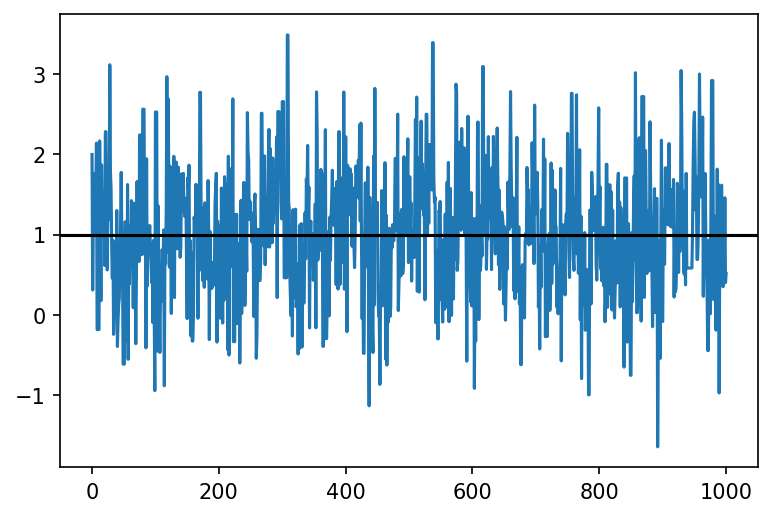

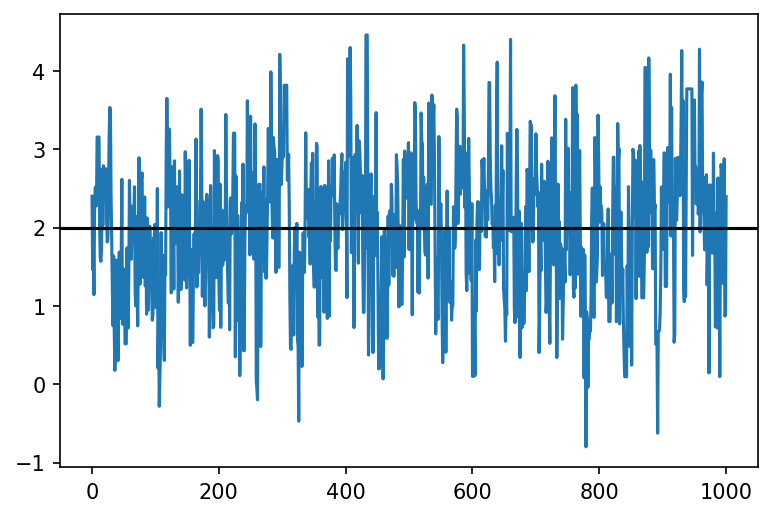

In [241]:
plt.figure(dpi=150)
plt.plot(np.arange(len(chain.T[0])), chain.T[0])
plt.axhline(mu[0], c='k')

plt.figure(dpi=150)
plt.plot(np.arange(len(chain.T[1])), chain.T[1])
plt.axhline(mu[1], c='k')

In [242]:
burn = int(len(chain) / 2)
for i, c in enumerate(chain.T):
    median = np.median(chain.T[i][burn:])
    e_plus = np.quantile(chain.T[i][burn:], 0.82) - np.median(chain.T[i][burn:])
    e_neg = np.median(chain.T[i][burn:]) - np.quantile(chain.T[i][burn:], 0.18)
    print(f'Par n°{i}')
    print(f'mean = {median:.3f} + {e_plus:.3f} - {e_neg:.3f}')

Par n°0
mean = 1.057 + 0.666 - 0.737
Par n°1
mean = 2.058 + 0.805 - 0.964
